In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
import json
from census import Census
import gmaps
import matplotlib.ticker as mtick
import matplotlib as mp
import scipy as sc
import scipy.stats as stats

# Census & gmaps API Keys
from config import (api_key, gkey)
c = Census(api_key, year=2018)

# Configure gmaps
gmaps.configure(api_key=gkey)

In [2]:
#import Racial Data CSV
csv_path = "Resources/Race Data Entry - CRDT.csv"
race_df = pd.read_csv(csv_path)

In [3]:
#Remove unneccessary columns and rows from race_df
del race_df['Deaths_Ethnicity_Unknown']
del race_df['Deaths_Ethnicity_NonHispanic']
del race_df['Deaths_Ethnicity_Hispanic']
del race_df['Cases_Ethnicity_Unknown']
del race_df['Cases_Ethnicity_NonHispanic']
del race_df['Cases_Ethnicity_Hispanic']
race_df = race_df.dropna(thresh=15)
race_df = race_df.dropna(subset={'Cases_Total'})
race_df = race_df[(race_df['Date'] == 20200715)]

In [4]:
#import state abbreviations dictionary
us_state_abbrev = {
    'AL': 'Alabama','AK': 'Alaska','AZ': 'Arizona','AR': 'Arkansas','CA': 'California',
    'CO': 'Colorado','CT': 'Connecticut','DE': 'Delaware','FL': 'Florida','GA': 'Georgia',
    'HI': 'Hawaii','ID': 'Idaho','IL': 'Illinois','IN': 'Indiana','IA': 'Iowa','KS': 'Kansas',
    'KY': 'Kentucky','LA': 'Louisiana','ME': 'Maine','MD': 'Maryland','MA': 'Massachusetts',
    'MI': 'Michigan','MN': 'Minnesota','MS': 'Mississippi','MO': 'Missouri','MT': 'Montana',
    'NE': 'Nebraska','NV': 'Nevada','NH': 'New Hampshire','NJ': 'New Jersey','NM': 'New Mexico',
    'NY': 'New York','NC': 'North Carolina','ND': 'North Dakota','OH': 'Ohio','OK': 'Oklahoma',
    'OR': 'Oregon','PA': 'Pennsylvania','RI': 'Rhode Island','SC': 'South Carolina',
    'SD': 'South Dakota','TN': 'Tennessee','TX': 'Texas','UT': 'Utah','VT': 'Vermont',
    'VA': 'Virginia','WA': 'Washington','WV': 'West Virginia','WI': 'Wisconsin','WY': 'Wyoming',
}

In [5]:
#Update the State to the full name in race_df
race_df['State']= race_df['State'].map(us_state_abbrev)
race_df.head()

,Date,State,Cases_Total,Cases_White,Cases_Black,Cases_LatinX,Cases_Asian,Cases_AIAN,Cases_NHPI,Cases_Multiracial,...,Deaths_Total,Deaths_White,Deaths_Black,Deaths_LatinX,Deaths_Asian,Deaths_AIAN,Deaths_NHPI,Deaths_Multiracial,Deaths_Other,Deaths_Unknown
0,20200715,Alaska,1631,672,39.0,NaN,65.0,204.0,53.0,43.0,...,17.0,11.0,0.0,NaN,2.0,3.0,1.0,0.0,0.0,0.0
2,20200715,Arkansas,30297,14673,6444.0,NaN,425.0,78.0,1832.0,NaN,...,335.0,188.0,87.0,NaN,6.0,0.0,29.0,NaN,23.0,2.0
4,20200715,Arizona,131354,21232,2882.0,30361.0,968.0,8322.0,NaN,NaN,...,2434.0,970.0,69.0,601.0,27.0,353.0,NaN,NaN,48.0,366.0
5,20200715,California,347634,39528,9697.0,122179.0,13167.0,482.0,1348.0,1621.0,...,7227.0,2190.0,621.0,3091.0,949.0,25.0,34.0,41.0,87.0,189.0
6,20200715,Colorado,38155,11869,1784.0,12957.0,807.0,189.0,119.0,365.0,...,1601.0,998.0,108.0,348.0,53.0,8.0,5.0,19.0,7.0,51.0


In [6]:
# Run Census Search to retrieve data on all states
census_data = c.acs5.get(("NAME", "B19013_001E", "B01003_001E", 
                          "B19301_001E",
                          "B23025_005E"), {'for': 'state:*'})

# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Column Reordering
census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                      "B19013_001E": "Household Income",
                                      "B19301_001E": "Per Capita Income",
                                      "NAME": "State", "state": "State1"})

# Final DataFrame
census_pd = census_pd[["State", "Population", "Household Income",
                       "Per Capita Income"]]

In [7]:
#Merge race and census data frames
data_df = pd.merge(race_df, census_pd, on="State")

In [8]:
#Convert object columns to numeric
data_df['Cases_Total']=data_df['Cases_Total'].apply(pd.to_numeric)
data_df['Cases_White']=data_df['Cases_White'].apply(pd.to_numeric)

In [9]:
#Replace the 'NaN' values in cells we will use in a sum with "0"
data_df['Cases_Black'] = data_df['Cases_Black'].fillna(0)
data_df['Cases_LatinX'] = data_df['Cases_LatinX'].fillna(0)
data_df['Cases_Asian'] = data_df['Cases_Asian'].fillna(0)
data_df['Cases_AIAN'] = data_df['Cases_AIAN'].fillna(0)
data_df['Cases_NHPI'] = data_df['Cases_NHPI'].fillna(0)
data_df['Cases_Multiracial'] = data_df['Cases_Multiracial'].fillna(0)
data_df['Cases_Other'] = data_df['Cases_Other'].fillna(0)
data_df['Cases_Unknown'] = data_df['Cases_Unknown'].fillna(0)
data_df.head()

,Date,State,Cases_Total,Cases_White,Cases_Black,Cases_LatinX,Cases_Asian,Cases_AIAN,Cases_NHPI,Cases_Multiracial,...,Deaths_LatinX,Deaths_Asian,Deaths_AIAN,Deaths_NHPI,Deaths_Multiracial,Deaths_Other,Deaths_Unknown,Population,Household Income,Per Capita Income
0,20200715,Alaska,1631,672,39.0,0.0,65.0,204.0,53.0,43.0,...,NaN,2.0,3.0,1.0,0.0,0.0,0.0,738516.0,76715.0,35874.0
1,20200715,Arkansas,30297,14673,6444.0,0.0,425.0,78.0,1832.0,0.0,...,NaN,6.0,0.0,29.0,NaN,23.0,2.0,2990671.0,45726.0,25635.0
2,20200715,Arizona,131354,21232,2882.0,30361.0,968.0,8322.0,0.0,0.0,...,601.0,27.0,353.0,NaN,NaN,48.0,366.0,6946685.0,56213.0,29265.0
3,20200715,California,347634,39528,9697.0,122179.0,13167.0,482.0,1348.0,1621.0,...,3091.0,949.0,25.0,34.0,41.0,87.0,189.0,39148760.0,71228.0,35021.0
4,20200715,Colorado,38155,11869,1784.0,12957.0,807.0,189.0,119.0,365.0,...,348.0,53.0,8.0,5.0,19.0,7.0,51.0,5531141.0,68811.0,36415.0


In [10]:
#import state diversity information
csv_path = "Resources/csvDataDiversity.csv"
div_df = pd.read_csv(csv_path)

#Merge the diversity dataframe with the full data dataframe
diversity_df = pd.merge(div_df, data_df, on="State")

#rearrange the columns
diversity_df = diversity_df[['Date', 'State', 'Population', 'Household Income', 'Per Capita Income',
                             'WhitePerc', 'BlackPerc', 'NativePerc', 'AsianPerc', 'IslanderPerc',
                             'OtherRacePerc', 'TwoOrMoreRacesPerc','Cases_Total', 'Cases_White',
                             'Cases_Black', 'Cases_LatinX', 'Cases_Asian', 'Cases_AIAN', 
                             'Cases_NHPI', 'Cases_Multiracial', 'Cases_Other', 'Cases_Unknown',
                             'Deaths_Total','Deaths_White', 'Deaths_Black', 'Deaths_LatinX', 
                             'Deaths_Asian', 'Deaths_AIAN', 'Deaths_NHPI', 'Deaths_Multiracial',
                             'Deaths_Other', 'Deaths_Unknown']]

#Write the dataframe to a csv file
diversity_df.to_csv("projectone_data.csv")

#View dataframe in jupyter notebook
diversity_df.head()

,Date,State,Population,Household Income,Per Capita Income,WhitePerc,BlackPerc,NativePerc,AsianPerc,IslanderPerc,...,Deaths_Total,Deaths_White,Deaths_Black,Deaths_LatinX,Deaths_Asian,Deaths_AIAN,Deaths_NHPI,Deaths_Multiracial,Deaths_Other,Deaths_Unknown
0,20200715,Alaska,738516.0,76715.0,35874.0,0.6484,0.0327,0.1444,0.0630,0.0120,...,17.0,11.0,0.0,NaN,2.0,3.0,1.0,0.0,0.0,0.0
1,20200715,Arizona,6946685.0,56213.0,29265.0,0.7722,0.0439,0.0446,0.0329,0.0020,...,2434.0,970.0,69.0,601.0,27.0,353.0,NaN,NaN,48.0,366.0
2,20200715,Arkansas,2990671.0,45726.0,25635.0,0.7700,0.1541,0.0067,0.0147,0.0027,...,335.0,188.0,87.0,NaN,6.0,0.0,29.0,NaN,23.0,2.0
3,20200715,California,39148760.0,71228.0,35021.0,0.6010,0.0579,0.0076,0.1432,0.0039,...,7227.0,2190.0,621.0,3091.0,949.0,25.0,34.0,41.0,87.0,189.0
4,20200715,Colorado,5531141.0,68811.0,36415.0,0.8417,0.0412,0.0099,0.0312,0.0015,...,1601.0,998.0,108.0,348.0,53.0,8.0,5.0,19.0,7.0,51.0


In [11]:
#pull top-five percentage white
diversity_df.sort_values(by=['WhitePerc'], inplace=True, ascending=False)
top_five_df = diversity_df.head()
top_five_df

,Date,State,Population,Household Income,Per Capita Income,WhitePerc,BlackPerc,NativePerc,AsianPerc,IslanderPerc,...,Deaths_Total,Deaths_White,Deaths_Black,Deaths_LatinX,Deaths_Asian,Deaths_AIAN,Deaths_NHPI,Deaths_Multiracial,Deaths_Other,Deaths_Unknown
13,20200715,Maine,1332813.0,55425.0,31253.0,0.9448,0.0134,0.0062,0.0112,0.0002,...,114.0,104.0,2.0,NaN,NaN,NaN,NaN,NaN,0.0,8.0
31,20200715,Vermont,624977.0,60076.0,33238.0,0.9433,0.0129,0.0034,0.0169,0.0003,...,56.0,53.0,NaN,NaN,2.0,NaN,NaN,NaN,1.0,0.0
21,20200715,New Hampshire,1343622.0,74057.0,38548.0,0.9303,0.0153,0.0016,0.0269,0.0003,...,394.0,326.0,8.0,11.0,3.0,NaN,NaN,NaN,10.0,36.0
35,20200715,Wyoming,581836.0,62268.0,32295.0,0.9144,0.0095,0.0242,0.0082,0.0009,...,22.0,9.0,0.0,2.0,0.0,9.0,NaN,NaN,0.0,2.0
8,20200715,Idaho,1687809.0,53089.0,26772.0,0.9049,0.0068,0.0135,0.0141,0.0016,...,110.0,101.0,1.0,NaN,2.0,1.0,NaN,NaN,1.0,0.0


In [12]:
#pull bottom five percentage white
diversity_df.sort_values(by=['WhitePerc'], inplace=True)
bottom_five_df = diversity_df.head()
bottom_five_df

,Date,State,Population,Household Income,Per Capita Income,WhitePerc,BlackPerc,NativePerc,AsianPerc,IslanderPerc,...,Deaths_Total,Deaths_White,Deaths_Black,Deaths_LatinX,Deaths_Asian,Deaths_AIAN,Deaths_NHPI,Deaths_Multiracial,Deaths_Other,Deaths_Unknown
14,20200715,Maryland,6003435.0,81868.0,40517.0,0.5619,0.2978,0.0026,0.0623,0.0005,...,3341.0,1431.0,1354.0,376.0,130.0,NaN,NaN,NaN,36.0,14.0
18,20200715,Mississippi,2988762.0,43567.0,23434.0,0.5859,0.3767,0.0046,0.0095,0.0002,...,1290.0,534.0,641.0,22.0,0.0,74.0,NaN,NaN,11.0,8.0
7,20200715,Georgia,10297484.0,55679.0,29523.0,0.5904,0.3146,0.0033,0.0391,0.0006,...,3091.0,1401.0,1436.0,171.0,49.0,4.0,6.0,NaN,12.0,12.0
3,20200715,California,39148760.0,71228.0,35021.0,0.6010,0.0579,0.0076,0.1432,0.0039,...,7227.0,2190.0,621.0,3091.0,949.0,25.0,34.0,41.0,87.0,189.0
0,20200715,Alaska,738516.0,76715.0,35874.0,0.6484,0.0327,0.1444,0.0630,0.0120,...,17.0,11.0,0.0,NaN,2.0,3.0,1.0,0.0,0.0,0.0


In [13]:
#Create summary rows for minority group totals and minority group infection totals
top_five_df["minority_groups"] = top_five_df["BlackPerc"] + top_five_df["NativePerc"] + top_five_df["AsianPerc"] + top_five_df["IslanderPerc"] + top_five_df["OtherRacePerc"] + top_five_df["TwoOrMoreRacesPerc"]
top_five_df["minority_group_infections"] = top_five_df["Cases_Black"] + top_five_df["Cases_LatinX"] + top_five_df["Cases_Asian"] + top_five_df["Cases_AIAN"] + top_five_df["Cases_NHPI"] + top_five_df["Cases_Multiracial"] + top_five_df["Cases_Other"] + top_five_df["Cases_Unknown"]
bottom_five_df["minority_group_infections"] = bottom_five_df["Cases_Black"] + bottom_five_df["Cases_LatinX"] + bottom_five_df["Cases_Asian"] + bottom_five_df["Cases_AIAN"] + bottom_five_df["Cases_NHPI"] + bottom_five_df["Cases_Multiracial"] + bottom_five_df["Cases_Other"] + bottom_five_df["Cases_Unknown"]
bottom_five_df["minority_groups"] = bottom_five_df["BlackPerc"] + bottom_five_df["NativePerc"] + bottom_five_df["AsianPerc"] + bottom_five_df["IslanderPerc"] + bottom_five_df["OtherRacePerc"] + bottom_five_df["TwoOrMoreRacesPerc"]

#create df for charts
racial_breakdown_df = pd.merge(top_five_df, bottom_five_df, how='outer')
racial_breakdown_df

C:\Users\becca\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\becca\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\becca\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

,Date,State,Population,Household Income,Per Capita Income,WhitePerc,BlackPerc,NativePerc,AsianPerc,IslanderPerc,...,Deaths_Black,Deaths_LatinX,Deaths_Asian,Deaths_AIAN,Deaths_NHPI,Deaths_Multiracial,Deaths_Other,Deaths_Unknown,minority_groups,minority_group_infections
0,20200715,Maine,1332813.0,55425.0,31253.0,0.9448,0.0134,0.0062,0.0112,0.0002,...,2.0,NaN,NaN,NaN,NaN,NaN,0.0,8.0,0.0551,1424.0
1,20200715,Vermont,624977.0,60076.0,33238.0,0.9433,0.0129,0.0034,0.0169,0.0003,...,NaN,NaN,2.0,NaN,NaN,NaN,1.0,0.0,0.0567,232.0
2,20200715,New Hampshire,1343622.0,74057.0,38548.0,0.9303,0.0153,0.0016,0.0269,0.0003,...,8.0,11.0,3.0,NaN,NaN,NaN,10.0,36.0,0.0698,2291.0
3,20200715,Wyoming,581836.0,62268.0,32295.0,0.9144,0.0095,0.0242,0.0082,0.0009,...,0.0,2.0,0.0,9.0,NaN,NaN,0.0,2.0,0.0857,1167.0
4,20200715,Idaho,1687809.0,53089.0,26772.0,0.9049,0.0068,0.0135,0.0141,0.0016,...,1.0,NaN,2.0,1.0,NaN,NaN,1.0,0.0,0.0951,6384.0
5,20200715,Maryland,6003435.0,81868.0,40517.0,0.5619,0.2978,0.0026,0.0623,0.0005,...,1354.0,376.0,130.0,NaN,NaN,NaN,36.0,14.0,0.4380,59622.0
6,20200715,Mississippi,2988762.0,43567.0,23434.0,0.5859,0.3767,0.0046,0.0095,0.0002,...,641.0,22.0,0.0,74.0,NaN,NaN,11.0,8.0,0.4140,27757.0
7,20200715,Georgia,10297484.0,55679.0,29523.0,0.5904,0.3146,0.0033,0.0391,0.0006,...,1436.0,171.0,49.0,4.0,6.0,NaN,12.0,12.0,0.4096,97881.0
8,20200715,California,39148760.0,71228.0,35021.0,0.6010,0.0579,0.0076,0.1432,0.0039,...,621.0,3091.0,949.0,25.0,34.0,41.0,87.0,189.0,0.3990,308106.0
9,20200715,Alaska,738516.0,76715.0,35874.0,0.6484,0.0327,0.1444,0.0630,0.0120,...,0.0,NaN,2.0,3.0,1.0,0.0,0.0,0.0,0.3516,959.0


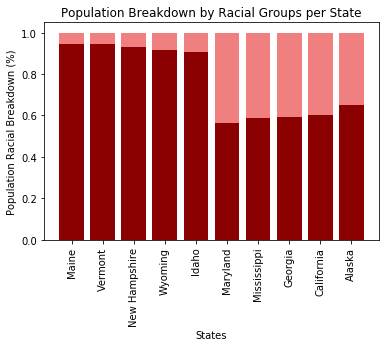

<Figure size 720x504 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [44]:
#Racial Breakdown per State
#Create dataframe for chart
racial_breakdown_bar = racial_breakdown_df[["State", "WhitePerc", "minority_groups"]]
states = racial_breakdown_bar["State"]
racial_breakdown_bar = racial_breakdown_bar.set_index(states)

#Plot the two bars for the bar chart
A = racial_breakdown_bar["WhitePerc"]
B = racial_breakdown_bar["minority_groups"]

#Plot the x axis
X = racial_breakdown_bar["State"]

#Plot the bar chart
plt.bar(X, A, color = 'darkred')
plt.bar(X, B, color = 'lightcoral', bottom = A)

#Chart formatting
plt.xticks(rotation='vertical')
plt.xlabel("States")
plt.ylabel("Population Racial Breakdown (%)")
plt.title("Population Breakdown by Racial Groups per State")
plt.figure(figsize=(10,7))
plt.tight_layout()


#Show and save chart
plt.show()
plt.savefig("Charts/Racial_Demographic_Breakdown.png")

No handles with labels found to put in legend.


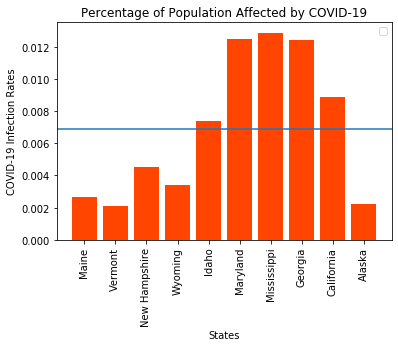

<Figure size 432x288 with 0 Axes>

In [15]:
#Bar chart for COVID-19 infection rates breakdown by state

#Determine % of population infected
percentage_infected = racial_breakdown_df["Cases_Total"] / racial_breakdown_df["Population"]
racial_breakdown_df["Percentage Infected"] = percentage_infected 

#Determine % of deaths
percentage_died = racial_breakdown_df["Deaths_Total"] / racial_breakdown_df["Population"]
racial_breakdown_df["Death Percentage"] = percentage_died

#Create dataframe for chart
covid_breakdown_bar = racial_breakdown_df[["State", "Percentage Infected"]]
states = covid_breakdown_bar["State"]
covid_breakdown_bar = covid_breakdown_bar.set_index(states)

#Plot the bars for the bar chart (left over from two bar chart)
A = covid_breakdown_bar["Percentage Infected"]

#Plot the x-axis
X = covid_breakdown_bar["State"]

#Chart formatting
plt.bar(X, A, color = 'orangered')
plt.xticks(rotation='vertical')

# use axhline
mean = covid_breakdown_bar["Percentage Infected"].mean()
plt.axhline(mean)

# Chart our data, give it a title, and label the axes
plt.xlabel("States")
plt.ylabel("COVID-19 Infection Rates")
plt.title("Percentage of Population Affected by COVID-19")
plt.legend(loc='best')

#Show and save chart
plt.show()
plt.tight_layout()
plt.savefig("Charts/%_Population_COVID_barchart.png")

No handles with labels found to put in legend.


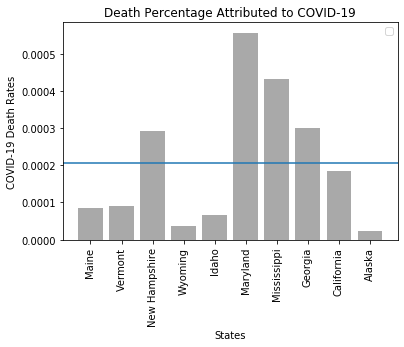

<Figure size 432x288 with 0 Axes>

In [27]:
#Bar chart for COVID-19 death rates breakdown by state

#Create data frame for chart
covid_breakdown_bar = racial_breakdown_df[["State", "Death Percentage"]]
states = covid_breakdown_bar["State"]
covid_breakdown_bar = covid_breakdown_bar.set_index(states)

#Plot the bars for the bar chart (left over from two bar chart)
B = covid_breakdown_bar["Death Percentage"]

#Plot the x-axis
X = covid_breakdown_bar["State"]

#Chart formatting
plt.bar(X, B, color = 'darkgray')
plt.xticks(rotation='vertical')
plt.xlabel("States")
plt.ylabel("COVID-19 Death Rates")
plt.title("Death Percentage Attributed to COVID-19")
plt.legend(loc='best')

# use axhline
mean = covid_breakdown_bar["Death Percentage"].mean()
plt.axhline(mean)

#Show and save chart
plt.show()
plt.tight_layout()
plt.savefig("Charts/%_Deaths_COVID_barchart.png")

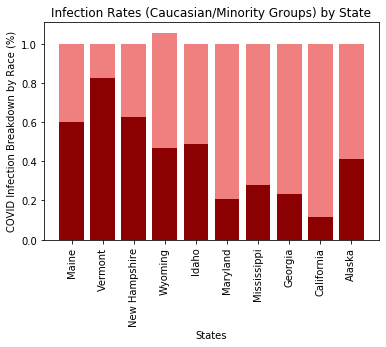

<Figure size 720x504 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [29]:
#Infection broken down by minorities

#Determine % of infections that are minority
racial_breakdown_df["minority_infection_rate"] = racial_breakdown_df["minority_group_infections"] / racial_breakdown_df["Cases_Total"]
racial_breakdown_df["white_infection_rate"] = racial_breakdown_df["Cases_White"] / racial_breakdown_df["Cases_Total"]

#Create data frame for chart
infection_breakdown_bar = racial_breakdown_df[["State", "minority_infection_rate", "white_infection_rate"]]
states = infection_breakdown_bar["State"]
infection_breakdown_bar = infection_breakdown_bar.set_index(states)

#Plot chart using madplotlib
A = infection_breakdown_bar["white_infection_rate"]
B = infection_breakdown_bar["minority_infection_rate"]
X = infection_breakdown_bar["State"]

#Chart formatting
plt.bar(X, A, color = 'darkred')
plt.bar(X, B, color = 'lightcoral', bottom = A)
plt.xticks(rotation='vertical')
plt.xlabel("States")
plt.ylabel("COVID Infection Breakdown by Race (%)")
plt.title("Infection Rates (Caucasian/Minority Groups) by State")
plt.figure(figsize=(10,7))
plt.tight_layout()

#Show and save chart
plt.show()
plt.savefig("Charts/Infection_Rate_Racial_Breakdown_by_State.png")

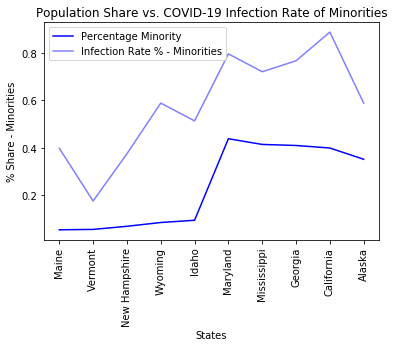

<Figure size 432x288 with 0 Axes>

In [45]:
# Population Share vs. COVID-19 Infection Rates 
percentage_minority = racial_breakdown_bar["minority_groups"]
state = infection_breakdown_bar["State"]

minority_groups_plot, = plt.plot(state, percentage_minority, color="blue", label="Percentage Minority" )

# Plot the infection rates
infection_rate_min, = plt.plot(state, infection_breakdown_bar["minority_infection_rate"], 
                        color="blue",alpha=.5,label = "Infection Rate % - Minorities")

# Create a legend for our chart
plt.legend(handles=[minority_groups_plot, infection_rate_min], loc="best")
plt.xticks(rotation='vertical')
plt.title("Population Share vs. COVID-19 Infection Rate of Minorities")
plt.xlabel("States")
plt.ylabel("% Share - Minorities")

# Show the chart
plt.show()
plt.savefig("Charts/Pop_Share_vs_Infection_Rate_Minorities.png")

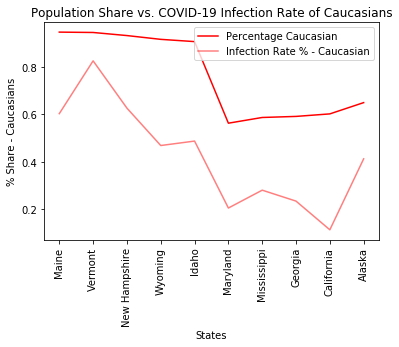

<Figure size 432x288 with 0 Axes>

In [46]:
# Plot the caucasion groups vs caucasion infection rates a line chart
percentage_minority = racial_breakdown_bar["minority_groups"]
state = infection_breakdown_bar["State"]

white_groups_plot, = plt.plot(state, racial_breakdown_bar["WhitePerc"], color="red", label="Percentage Caucasian" )

# Plot the infection rates
infection_rate_caucasion, = plt.plot(state, racial_breakdown_df["white_infection_rate"], 
                        color="red",alpha=.5,label="Infection Rate % - Caucasian")

# Create a legend for our chart
plt.legend(handles=[white_groups_plot,infection_rate_caucasion], loc="best")
plt.xticks(rotation='vertical')
plt.title("Population Share vs. COVID-19 Infection Rate of Caucasians")
plt.xlabel("States")
plt.ylabel("% Share - Caucasians")

# Show and save the chart
plt.show()
plt.savefig("Charts/Pop_Share_vs_Infection_Rate_Caucasian.png")

slope: 29.651046 intercept: 0.032779
R-squared: 0.577733


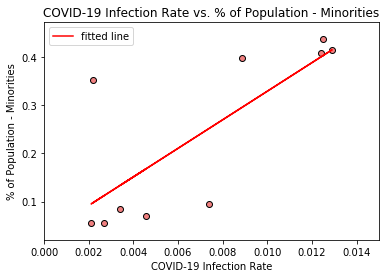

<Figure size 432x288 with 0 Axes>

In [39]:
#Set up values for scatterplot
infections = racial_breakdown_df['Percentage Infected']
demographics = racial_breakdown_df["minority_groups"]

# Set up scatterplot
plt.scatter(infections, demographics, marker="o", facecolors="lightcoral", edgecolors="black")

# Chart Formatting
plt.xlim(0,.015)
plt.title("COVID-19 Infection Rate vs. % of Population - Minorities")
plt.xlabel("COVID-19 Infection Rate")
plt.ylabel("% of Population - Minorities")

#Set up linear regression
slope, intercept, r_value, p_value, std_err = linregress(infections, demographics)
print("slope: %f intercept: %f" % (slope,intercept))
print("R-squared: %f" % r_value**2)
plt.plot(infections, intercept + slope*np.asarray(infections), "r", label="fitted line")

# Show and save the chart
plt.legend()
plt.show()
plt.savefig("Charts/Infection_Rate_Minorities_Scatterplot.png")

slope: -29.658297 intercept: 0.967261
R-squared: 0.577801


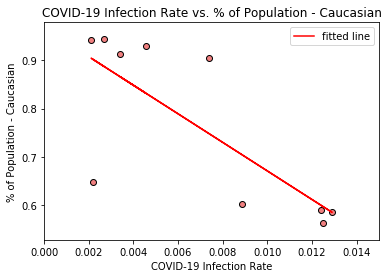

<Figure size 432x288 with 0 Axes>

In [40]:
#Set up values for scatterplot
infections = racial_breakdown_df['Percentage Infected']
demographics = racial_breakdown_df["WhitePerc"]

# Set up scatterplot
plt.scatter(infections, demographics, marker="o", facecolors="lightcoral", edgecolors="black")

# Chart Formatting
plt.xlim(0,.015)
plt.title("COVID-19 Infection Rate vs. % of Population - Caucasian")
plt.xlabel("COVID-19 Infection Rate")
plt.ylabel("% of Population - Caucasian")

#Set up linear regression
slope, intercept, r_value, p_value, std_err = linregress(infections, demographics)
print("slope: %f intercept: %f" % (slope,intercept))
print("R-squared: %f" % r_value**2)
plt.plot(infections, intercept + slope*np.asarray(infections), "r", label="fitted line")

# Show and save the chart
plt.legend()
plt.show()
plt.savefig("Charts/Infection_Rate_Caucasian_Scatterplot.png")

In [41]:
#Calculate T-Test
tstat, pvalue=stats.ttest_ind(racial_breakdown_df["Cases_White"], racial_breakdown_df['minority_groups'], equal_var=1)
print(tstat)
print(pvalue)

2.57612564352716
0.01902977383351725
